In [1]:
import pandas as pd
from scipy.optimize import linprog
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Some layout settings for the plots
fontsize_ticks = 14
fontsize_xylabels = 16
fontsize_title = 16

In [3]:
# Read df_movements (df_movements is the output of agps_proc.ipynb)
df_movements = pd.read_pickle('LSZH_MAY_SEP_df_movements.pkl')

# Filter for takeoff only
df_movements = df_movements.query('isTakeoff', engine='python')

# Get rid of departures classified as runway 14 -> These are outliers (no aircraft take off on runway 14 at ZRH in real life)
df_movements = df_movements.query('takeoffRunway!="14"')

# Add date column
df_movements['date'] = df_movements['lineupTime'].dt.date

# Overwrite stand_area == "unkown" with the first character of the parking_position (if available)
df_movements['stand_area'] = df_movements['stand_area'].replace("unkown", "unknown")

# Define mask: not NA and does not start with 'V'
mask = df_movements['parking_position'].notna() & ~df_movements['parking_position'].str.startswith('V')

# Overwrite stand_area with first letter of parking_position where mask is True
df_movements.loc[mask, 'stand_area'] = df_movements.loc[mask, 'parking_position'].str[0]

# Drop not required columns
df_movements = df_movements.drop(columns=['MESengine180', 'MESapu180', 'normTAXIengine180', 'min_compute_gs_diff',
       'max_compute_gs_diff', 'max_cumdist_diff', 'first_altitude', 'normTAXIengine', 'extAGPSapu',
       'extAGPStug'])

# Convert all relevant timestamp columns to timezone-naive
df_movements['startTaxi'] = pd.to_datetime(df_movements['startTaxi']).dt.tz_localize(None)
df_movements['lineupTime'] = pd.to_datetime(df_movements['lineupTime']).dt.tz_localize(None)
df_movements['startPushback'] = pd.to_datetime(df_movements['startPushback']).dt.tz_localize(None)
df_movements['date'] = pd.to_datetime(df_movements['date']).dt.tz_localize(None)

df_movements

,flight_id,icao24,callsign,isTakeoff,isPushback,startPushback,startTaxi,lineupTime,taxiDuration,taxiDistance,...,stand_area,typecode,icaoaircrafttype,nEngines,engIdleFF,APUhighFF,APUnormalFF,MESengine,MESapu,date
2,AAL93_11938,aae1ea,AAL93,True,False,<NA>,2024-05-05 09:51:52,2024-05-05 10:04:55,0 days 00:13:03,1.250523,...,E,B788,L2J,2,0.223,262,238,93.66,16.666667,2024-05-05
3,AAL93_11941,aae597,AAL93,True,False,<NA>,2024-05-01 09:56:35,2024-05-01 10:03:06,0 days 00:06:31,1.237633,...,E,B788,L2J,2,0.223,262,238,93.66,16.666667,2024-05-01
4,AAL93_11945,ab1839,AAL93,True,False,<NA>,2024-05-09 10:06:29,2024-05-09 10:19:47,0 days 00:13:18,1.0074,...,E,B788,L2J,2,0.223,262,238,93.66,16.666667,2024-05-09
5,AAL93_11947,ab1fa7,AAL93,True,False,<NA>,2024-05-03 09:44:34,2024-05-03 09:56:52,0 days 00:12:18,0.440692,...,E,B788,L2J,2,0.223,262,238,93.66,16.666667,2024-05-03
6,AAL93_11950,ab236a,AAL93,True,False,<NA>,2024-05-04 09:44:18,2024-05-04 09:52:56,0 days 00:08:38,0.69721,...,E,B788,L2J,2,0.223,262,238,93.66,16.666667,2024-05-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53354,VLG7516_174,344099,VLG7516,True,False,<NA>,2024-09-27 12:52:21,2024-09-27 12:55:13,0 days 00:02:52,0.305183,...,unknown,A320,L2J,2,0.107,130,110,44.94,8.000000,2024-09-27
53355,VLG7516_222,344697,VLG7516,True,False,<NA>,2024-09-30 08:53:38,2024-09-30 08:55:29,0 days 00:01:51,0.332877,...,H,A320,L2J,2,0.107,130,110,44.94,8.000000,2024-09-30
53356,VLG7516_247,345645,VLG7516,True,False,<NA>,2024-09-23 08:40:45,2024-09-23 08:46:04,0 days 00:05:19,0.881704,...,AB Courtyard,A320,L2J,2,0.107,130,110,44.94,8.000000,2024-09-23
53357,VLG7516_270,346090,VLG7516,True,False,<NA>,2024-09-25 12:47:38,2024-09-25 12:52:50,0 days 00:05:12,0.307059,...,unknown,A20N,L2J,2,0.080,130,110,33.60,8.000000,2024-09-25


### Fuel Consumption during Normal Taxi & AGPS-assisted Taxi

![Taxi Modes Fuel Consumption](ATRS_taxi.jpg)

In [4]:
### Normal Taxi Fuel Consumption
from agps_config import DEFAULT_STARTUP_TIME, DEFAULT_WARMUP_TIME, DEFAULT_SFC_AGPS
startupTime = DEFAULT_STARTUP_TIME      # In Seconds
warmupTime = DEFAULT_WARMUP_TIME        # In Seconds
sfc_tug = DEFAULT_SFC_AGPS       # Specific fuel consumption of tug (kg/s)

# Duration of pushback
dur_PB_raw = (df_movements['startTaxi'] - df_movements['startPushback'])
dur_PB = np.where(
    df_movements['startPushback'].isna(),
    0,
    dur_PB_raw.dt.total_seconds()
)
dur_PB = np.clip(dur_PB, a_min=startupTime, a_max=None)

# Fuel consumption of PB truck during Pushback
F_PBtug = dur_PB * sfc_tug  # dur_PB is in seconds, sfc_tug should be in kg/s

# APU normal mode on stand/during pushback
dur_APUnorm = np.clip(dur_PB - startupTime, a_min=0, a_max=None)
F_APUnorm = dur_APUnorm * df_movements['APUnormalFF'] / 3600  # FF in kg/h, duration in sec

# APU & Engine during MES & WUP
F_mw = df_movements['MESapu'] + df_movements['MESengine']

# Engine during conventional taxi (minus WUP period)
dur_convTaxi = ((df_movements['lineupTime'] - df_movements['startTaxi']).dt.total_seconds() - warmupTime)
dur_convTaxi = dur_convTaxi.clip(lower=warmupTime)  # keep as Series to use .clip()
F_convTaxi = dur_convTaxi * df_movements['nEngines'] * df_movements['engIdleFF']  # FF in kg/s

# Final normal fuel consumption of flight i
df_movements['F_i_norm'] = F_mw + F_convTaxi + F_PBtug + F_APUnorm

In [5]:
### AGPS-assisted Taxi Fuel Consumption

# Calculate startMovement as the earlier of the two times
df_movements['startMovement'] = df_movements[['startTaxi', 'startPushback']].min(axis=1, skipna=True)

# Duration of AGPS-assisted taxi
dur_AGPS = ((df_movements.lineupTime-df_movements.startMovement).dt.total_seconds()-startupTime-warmupTime).clip(lower=0)

# APU & Engine during MES & WUP
F_mw = df_movements['MESapu'] + df_movements['MESengine']

# Fuel Consumption of APU during AGPS-assisted Taxi
F_APUagps = dur_AGPS * df_movements['APUnormalFF'] / 3600

# Fuel consumption of tug during AGPS-assisted taxi
F_AGPStug = (dur_AGPS + startupTime) * sfc_tug

# Final AGPS-assisted fuel consumption of flight i
df_movements['F_i_agps'] = F_mw + F_APUagps + F_AGPStug


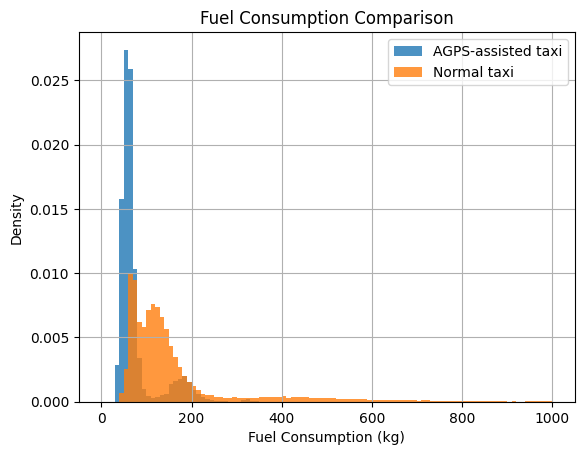

In [6]:
df_movements['F_i_agps'].hist(bins=100, range=(0, 1000), label='AGPS-assisted taxi', density=True, alpha=0.8)
df_movements['F_i_norm'].hist(bins=100, range=(0, 1000), label='Normal taxi', density=True, alpha=0.8)

plt.xlabel('Fuel Consumption (kg)')
plt.ylabel('Density')
plt.legend()
plt.title('Fuel Consumption Comparison')
plt.grid(True)
plt.show()

In [8]:
df_movements.columns

Index(['flight_id', 'icao24', 'callsign', 'isTakeoff', 'isPushback',
       'startPushback', 'startTaxi', 'lineupTime', 'taxiDuration',
       'taxiDistance', 'takeoffRunway', 'parking_position', 'stand_area',
       'typecode', 'icaoaircrafttype', 'nEngines', 'engIdleFF', 'APUhighFF',
       'APUnormalFF', 'MESengine', 'MESapu', 'date', 'F_i_norm',
       'startMovement', 'F_i_agps'],
      dtype='object')

***
# Optimization Model
***

**Tug allocation rule:** 
* Dedication
* Common-use


**Tug dispatch strategy**
1. FCFS
2. Only large, only small A/C
3. Consider only aircraft from certain stand areas
4. Consider only "simple" tug movements (meaning no runway crossings)


**Stuff to be fixed / improved:**
* Tug must consume fuel on turnaround as well
* Turnaround time cannot be fixed but rather depends on distance travelled by the tug
* Add buffer time for attachment and detatchment of tug
* If stand_area unknown, check if parking_position

***
# Fuel Reduction = f(nTugs)
***

In [59]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import importlib
import agps_optim

# Reload the module to pick up changes
importlib.reload(agps_optim)

from agps_optim import optimize_day

ImportError: cannot import name 'optimize_day' from 'agps_optim' (/Users/wate/Documents/GitHub/osn24_agps/agps_optim.py)

In [ ]:
# Specific fuel consumption of conventional pushback tug: 22.7l/h --> 19.3kg/h (sfc value is from Postorino et al. 2019)
sfc_tug = 20  # kg/h

# Calculate tug fuel consumption per flight (kg)
df_movements['extAGPStug'] = (df_movements['taxiDuration'].dt.total_seconds()/3600) * sfc_tug


df_movements['date'] = df_movements['lineupTime'].dt.date

In [7]:
def run_optimization_for_tugs(
    n_tugs,
    df_filtered,
    num_workers,
    allowed_aircraft_types,
    allowed_combinations,
    T_turn,
    solver_method
):
    results = []
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {
            executor.submit(
                optimize_day,
                date,
                subset_df,
                n_tugs,
                T_turn,
                solver_method,
                allowed_aircraft_types,
                allowed_combinations
            ): date
            for date, subset_df in df_filtered.groupby('date')
        }
        
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"n_tugs = {n_tugs}"):
            try:
                result = future.result()
                if not result.empty:
                    results.append(result)
            except Exception as e:
                print(f"Error processing a day's optimization: {e}")
    
    # Combine results into a single DataFrame for the current n_tugs
    if results:
        df_results = pd.concat(results, ignore_index=True)
        df_results['n_tugs'] = n_tugs  # Add column to track the number of tugs used for each run
        return df_results
    else:
        return pd.DataFrame()

In [ ]:
# All Aircrafttypes, All Stand-Runway Combinations Allowed
config_1 = {
    'name': 'allTypes_allCombinations',
    'allowed_aircraft_types': [],
    'allowed_combinations': []
}

# Narrow Body Aircraft only, All Stand-Runway Combinations Allowed
config_2 = {
    'name': 'Narrow_Bodys_allCombinations',
    'allowed_aircraft_types': ['A320', 'A321', 'A20N','A21N','A319', 
                          'BCS1', 'BCS3', 
                          'B733', 'B734', 'B735', 'B736', 'B737', 'B738', 'B739', 'B38M', 'B39M',
                          'E190','E195', 'E295', 'E75L', 'E75S'],
    'allowed_combinations': []  # No restriction, all combinations allowed
}

# All Aircraft Types, only Stand-Runway combination without runway crossings
config_3 = {
    'name': 'no_runway_crossings',
    'allowed_aircraft_types': [],
    'allowed_combinations': [('A North', '28'),
                             ('A North', '34'),
                             ('AB Courtyard', '28'),
                             ('AB Courtyard', '34'),
                             ('B South', '28'),
                             ('B South', '34'),
                             ('C', '28'),
                             ('C', '34'),
                             ('D', '28'),
                             ('D', '34'),
                             ('G', '28'),
                             ('G', '34'),
                             ('T', '28'),
                             ('T', '34'),
                             ('I', '28'),
                             ('I', '34'),
                             ('F', '28'),
                             ('F', '34'),
                             ('GAC', '28'),
                             ('GAC', '34'),
                             ('E', '32'),
                             ('E', '16')
                             ]
}


# List of configurations to test
configs = [config_1]

# Store results in a dictionary where keys are configuration names
results_dict = {}

# Run the optimization for different numbers of tugs (0 to 20)
tug_counts = list(range(0, 21))
num_workers = 10
T_turn = 15  # Turnaround time in minutes
solver_method = "highs"  # Use the efficient 'highs' solver

for config in configs:
    config_name = config['name']
    results_dict[config_name] = {}

    print(f"Running configuration: {config_name}")

    for n_tugs in tug_counts:
        #print(f"Running optimization for: {config_name}, n_tugs = {n_tugs}")
        
        df_tugs_results = run_optimization_for_tugs(
            n_tugs,
            df_movements,
            num_workers,
            config['allowed_aircraft_types'],
            config['allowed_combinations'],
            T_turn,
            solver_method
        )
        
        results_dict[config_name][n_tugs] = df_tugs_results  # Store results in dictionary
    

Running configuration: allTypes_allCombinations


n_tugs = 20: 100%|██████████| 153/153 [00:03<00:00, 41.04it/s]


Running configuration: Narrow_Bodys_allCombinations


n_tugs = 20: 100%|██████████| 153/153 [00:03<00:00, 45.24it/s]

Running configuration: no_runway_crossings



n_tugs = 20: 100%|██████████| 153/153 [00:03<00:00, 42.87it/s]


In [17]:
addOSN24_data = True

# Create a list to collect the data for the final DataFrame
df_results_list = []

# Iterate through each configuration name in results_dict
for config_name, config_results in results_dict.items():
    for n_tugs, df_tugs_results in config_results.items():
        if not isinstance(df_tugs_results, pd.DataFrame) or df_tugs_results.empty:
            continue  # Skip if there is no data for the specific n_tugs
        
        # Calculate fuel_AGPS for the current DataFrame
        fuel_AGPS = (
            df_tugs_results['Adjusted_Fuel_Consumption'].sum() +
            df_tugs_results['MESengine'].sum() +
            df_tugs_results['MESapu'].sum()
        )

        # Calculate baseline for the current DataFrame
        baseline = (
            df_tugs_results['MESengine'].sum() +
            df_tugs_results['MESapu'].sum() +
            df_tugs_results['normTAXIengine'].sum()
        )

        # Append the result as a dictionary to the list
        df_results_list.append({
            'config_name': config_name,
            'nTugs': n_tugs,
            'baseline': baseline,
            'AGPS_optim': fuel_AGPS,
        })

# Convert the list to a DataFrame
df_results = pd.DataFrame(df_results_list)

if addOSN24_data:
    # Read OSN24 Legacy Results
    df_OSN24_results = pd.read_pickle('fuel_vs_nTugs_OSN24.pkl')

    # Merge for each configuration separately
    df_results = pd.merge(
        df_results,
        df_OSN24_results[['nTugs', 'AGPS_rwy_all']],
        on='nTugs',
        how='left'
    )

    df_results.rename(columns={'AGPS_rwy_all': 'AGPS_OSN24'}, inplace=True)
    df_results['AGPS_OSN24'] = df_results['AGPS_OSN24'] * 1000  # Scale if necessary

df_results

,config_name,nTugs,baseline,AGPS_optim,AGPS_OSN24
0,allTypes_allCombinations,0,8.851565e+06,8.851565e+06,8.851565e+06
1,allTypes_allCombinations,1,8.851565e+06,8.067554e+06,7.750379e+06
2,allTypes_allCombinations,2,8.851565e+06,7.485958e+06,6.941953e+06
3,allTypes_allCombinations,3,8.851565e+06,7.010640e+06,6.308183e+06
4,allTypes_allCombinations,4,8.851565e+06,6.612704e+06,5.768885e+06
...,...,...,...,...,...
58,no_runway_crossings,16,8.851565e+06,5.871213e+06,3.696792e+06
59,no_runway_crossings,17,8.851565e+06,5.845522e+06,3.685156e+06
60,no_runway_crossings,18,8.851565e+06,5.824906e+06,3.678366e+06
61,no_runway_crossings,19,8.851565e+06,5.808561e+06,3.675096e+06


***
# MILP
***

In [7]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import pandas as pd

import importlib
import agps_optim

# Reload the module to pick up changes
importlib.reload(agps_optim)

from agps_optim import optimize_day_MILP_gurobi

def run_optimization_for_tugs_MILP(
    n_tugs,
    df_filtered,
    num_workers,
    allowed_aircraft_types,
    allowed_combinations,
    buffer_time,  
    distance_matrix  # Add this line to accept distance matrix as an argument
):
    results = []
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {
            executor.submit(
                optimize_day_MILP_gurobi,
                date,
                subset_df,
                n_tugs,
                distance_matrix,  # Pass distance_matrix here
                buffer_time,
                allowed_aircraft_types,
                allowed_combinations
            ): date
            for date, subset_df in df_filtered.groupby('date')
        }
        
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"n_tugs = {n_tugs}"):
            try:
                result = future.result()
                if not result.empty:
                    results.append(result)
            except Exception as e:
                print(f"Error processing a day's optimization: {e}")
    
    # Combine results into a single DataFrame for the current n_tugs
    if results:
        valid_results = []

        for df in results:
            if isinstance(df, pd.DataFrame) and not df.empty and not df.isna().all().all():
                valid_results.append(df)

        if len(valid_results) > 0:
            df_results = pd.concat(valid_results, ignore_index=True)
        else:
            df_results = pd.DataFrame()    
    else:
        df_results = pd.DataFrame()
        
    return df_results  # Return the final DataFrame

In [8]:
# All Aircrafttypes, All Stand-Runway Combinations Allowed
config_0 = {
    'name': 'allTypes_allCombinations',
    'allowed_aircraft_types': [],
    'allowed_combinations': []
}

# Narrow Body Aircraft only, All Stand-Runway Combinations Allowed
config_1 = {
    'name': 'Narrow_Bodys_allCombinations',
    'allowed_aircraft_types': ['A320', 'A321', 'A20N','A21N','A319', 
                          'BCS1', 'BCS3', 
                          'B733', 'B734', 'B735', 'B736', 'B737', 'B738', 'B739', 'B38M', 'B39M',
                          'E190','E195', 'E295', 'E75L', 'E75S'],
    'allowed_combinations': []  # No restriction, all combinations allowed
}

# Wide Body Aircraft only, All Stand-Runway Combinations Allowed
config_2 = {
    'name': 'Wide_Bodys_allCombinations',
    'allowed_aircraft_types': ['A332', 'A333', 'A339', 'A343', 'A346', 'A35K', 'A388',
                          'B744', 'B762', 'B763','B788', 'B789', 'B78X', 'B772', 'B773', 'B77L', 'B77W',],
    'allowed_combinations': []  # No restriction, all combinations allowed
}

# All Aircraft Types, only Dock E
config_3 = {
    'name': 'dock_e_only',
    'allowed_aircraft_types': [],
    'allowed_combinations': [('E', '32'),
                             ('E', '16'),
                             ('E', '28'),
                             ('E', '10'),
                             ('E', '34'),
                             ]
}

# All Aircraft Types, only Stand-Runway combination without runway crossings
config_4 = {
    'name': 'no_runway_crossings',
    'allowed_aircraft_types': [],
    'allowed_combinations': [('A North', '28'),
                             ('A North', '34'),
                             ('AB Courtyard', '28'),
                             ('AB Courtyard', '34'),
                             ('B South', '28'),
                             ('B South', '34'),
                             ('C', '28'),
                             ('C', '34'),
                             ('D', '28'),
                             ('D', '34'),
                             ('G', '28'),
                             ('G', '34'),
                             ('T', '28'),
                             ('T', '34'),
                             ('I', '28'),
                             ('I', '34'),
                             ('F', '28'),
                             ('F', '34'),
                             ('GAC', '28'),
                             ('GAC', '34'),
                             ('E', '32'),
                             ('E', '16')
                             ]
}

In [ ]:
print(len(df_movements))
print(len(df_movements[df_movements.typecode.isin(['A332', 'A333', 'A339', 'A343', 'A346', 'A35K', 'A388',
                          'B744', 'B762', 'B763','B788', 'B789', 'B78X', 'B772', 'B773', 'B77L', 'B77W',])]))

print(len(df_movements[df_movements.typecode.isin(['A320', 'A321', 'A20N','A21N','A319', 
                          'BCS1', 'BCS3', 
                          'B733', 'B734', 'B735', 'B736', 'B737', 'B738', 'B739', 'B38M', 'B39M',
                          'E190','E195', 'E295', 'E75L', 'E75S'])]))

46419
5469
38623


## MILP (Gurobi)

In [ ]:
# List of configurations to test
configs = [config_0]

# Store results in a dictionary where keys are configuration names
results_dict = {}

# Run the optimization for different numbers of tugs (0 to 20)
tug_counts = list(range(0, 20))
num_workers = 10
buffer_time = pd.Timedelta(minutes=15)  # Buffer time in minutes as a pd.Timedelta
distance_matrix = pd.DataFrame(
    data=[  # A_N    AB_C    B_S     C,      D,      E,      F,      G,      H,      I,      T,      GAC     unknown
        [4.4, 3.8, 3.7, 3.5, 3.3, 5.3, 4.6, 2.8, 4.4, 4.7, 3.3, 5.0, 2.8],  # RWY 10
        [3.6, 3.6, 3.8, 4.4, 4.2, 2.1, 3.7, 5.1, 3.6, 3.9, 4.6, 4.1, 2.8],  # RWY 16
        [1.3, 1.5, 1.5, 2.0, 1.8, 2.0, 0.6, 2.7, 1.2, 1.5, 2.2, 0.4, 2.8],  # RWY 28
        [2.4, 2.5, 2.7, 3.3, 3.0, 1.1, 1.8, 3.8, 2.4, 2.7, 3.3, 1.6, 2.8],  # RWY 32
        [2.2, 1.7, 1.4, 1.3, 1.0, 3.0, 2.4, 0.5, 2.2, 2.4, 1.0, 2.7, 2.8],  # RWY 34
    ],
    index=["10", "16", "28", "32", "34"],  # Takeoff runways as rows
    columns=[
        "A North",
        "AB Courtyard",
        "B South",
        "C",
        "D",
        "E",
        "F",
        "G",
        "H",
        "I",
        "T",
        "GAC",
        "unknown",
    ],  # Stand Areas as columns
)

for config in configs:
    config_name = config['name']
    results_dict[config_name] = {}

    print(f"\nRunning configuration: {config_name}")

    # Count the total number of days to process
    total_days = len(df_movements['date'].unique()) * len(tug_counts)
    progress_bar = tqdm(total=total_days, desc=f"Processing {config_name}", unit="day")

    for n_tugs in tug_counts:
        df_tugs_results = run_optimization_for_tugs_MILP(
            n_tugs=n_tugs,
            df_filtered=df_movements,
            num_workers=num_workers,
            allowed_aircraft_types=config['allowed_aircraft_types'],
            allowed_combinations=config['allowed_combinations'],
            buffer_time=buffer_time,
            distance_matrix=distance_matrix
        )
        
        results_dict[config_name][n_tugs] = df_tugs_results  # Store results in dictionary
        
        # Update progress bar after each run for a particular n_tugs
        progress_bar.update(len(df_movements['date'].unique()))

    progress_bar.close()

In [36]:
addOSN24_data = True

# Create a list to collect the data for the final DataFrame
df_results_list = []

# Iterate through each configuration name in results_dict
for config_name, config_results in results_dict.items():
    for n_tugs, df_tugs_results in config_results.items():
        if not isinstance(df_tugs_results, pd.DataFrame) or df_tugs_results.empty:
            continue  # Skip if there is no data for the specific n_tugs
        
        # Calculate fuel_AGPS for the current DataFrame
        fuel_AGPS = df_tugs_results['Adjusted_Fuel_Consumption'].sum()

        # Calculate baseline for the current DataFrame
        baseline = df_tugs_results['F_i_norm'].sum()

        # Append the result as a dictionary to the list
        df_results_list.append({
            'config_name': config_name,
            'nTugs': n_tugs,
            'baseline': baseline,
            'AGPS_optim': fuel_AGPS,
        })

# Convert the list to a DataFrame
df_results = pd.DataFrame(df_results_list)

# Adding OSN24 Legacy Data if requested
if addOSN24_data:
    # Read OSN24 Legacy Results
    df_OSN24_results = pd.read_pickle('fuel_vs_nTugs_OSN24.pkl')

    # Merge for each configuration separately
    df_results = pd.merge(
        df_results,
        df_OSN24_results[['nTugs', 'AGPS_rwy_all']],
        on='nTugs',
        how='left'
    )

    df_results.rename(columns={'AGPS_rwy_all': 'AGPS_OSN24'}, inplace=True)
    df_results['AGPS_OSN24'] = df_results['AGPS_OSN24'] * 1000  # Scale if necessary

# Display the results
df_results

,config_name,nTugs,baseline,AGPS_optim,AGPS_OSN24
0,allTypes_allCombinations,0,7.705662e+06,7.705662e+06,8.851565e+06
1,allTypes_allCombinations,1,7.705662e+06,6.912081e+06,7.750379e+06
2,allTypes_allCombinations,2,7.705662e+06,6.334424e+06,6.941953e+06
3,allTypes_allCombinations,3,7.705662e+06,5.868535e+06,6.308183e+06
4,allTypes_allCombinations,4,7.705662e+06,5.480779e+06,5.768885e+06
5,allTypes_allCombinations,5,7.705662e+06,5.152236e+06,5.322914e+06
6,allTypes_allCombinations,6,7.705662e+06,4.869170e+06,4.952342e+06
7,allTypes_allCombinations,7,7.705662e+06,4.625630e+06,4.658014e+06
8,allTypes_allCombinations,8,7.705662e+06,4.415817e+06,4.416834e+06
9,allTypes_allCombinations,9,7.705662e+06,4.239160e+06,4.226376e+06


***
# Illustrations

<function matplotlib.pyplot.show(close=None, block=None)>

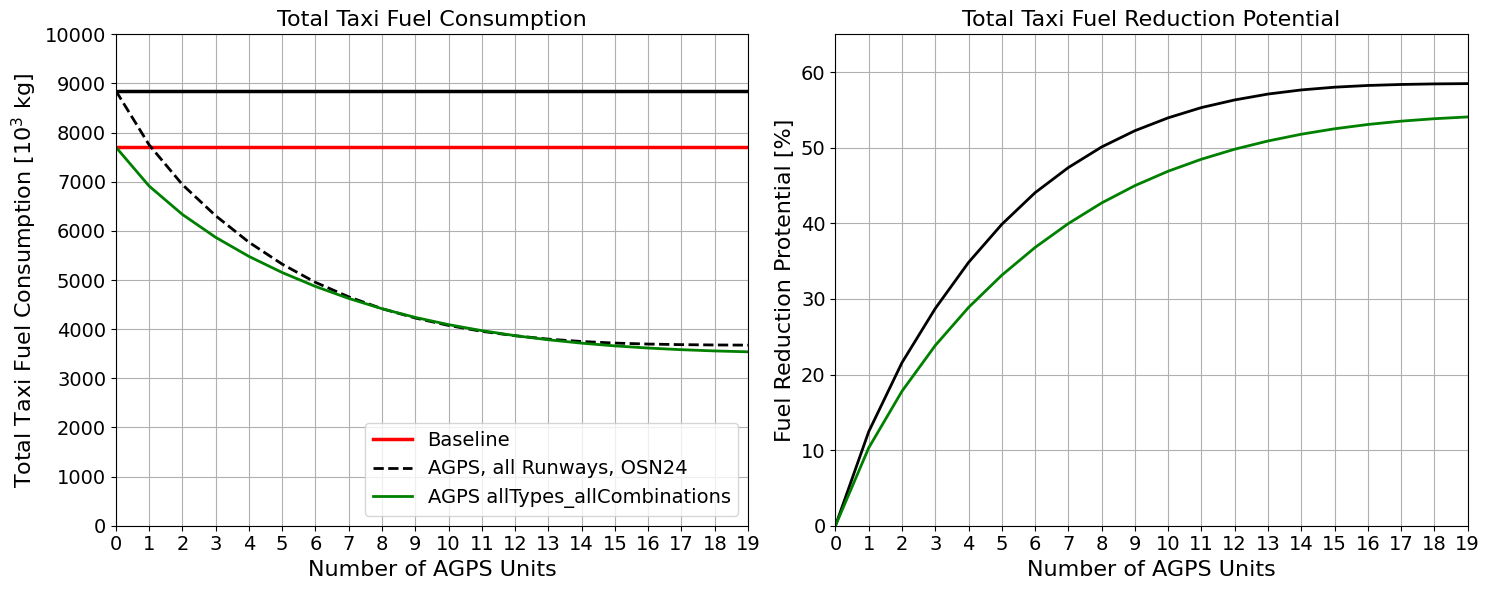

In [51]:
from matplotlib.ticker import MultipleLocator
addOSN24_data = True

colors = ['g' ,'b', 'm', 'c', 'y']

config_names= df_results['config_name'].unique()

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

baseline = df_results.query('config_name == @config_names[0]').baseline.iloc[0]



######## Subplot 0 #########
axs[0].axhline(y=baseline, color='r', linestyle='-', linewidth=2.5, label='Baseline')

if addOSN24_data:
        baseline_OSN24 = df_results.query('config_name == @config_names[0]').AGPS_OSN24.iloc[0]
        axs[0].axhline(y=baseline_OSN24, color='k', linestyle='-', linewidth=2.5)

        axs[0].plot(df_results.query('config_name == @config_names[0]').nTugs, 
                    df_results.query('config_name == @config_names[0]').AGPS_OSN24,
                    color= 'k',
                    linestyle='--',
                    label='AGPS, all Runways, OSN24',
                    linewidth = 2)

for i, config_name in enumerate(config_names):
        axs[0].plot(df_results.query('config_name == @config_name').nTugs, 
                df_results.query('config_name == @config_name').AGPS_optim, 
                color = colors[i],
                label='AGPS ' + config_name,
                linewidth = 2)

axs[0].set_xlim((min(df_results.nTugs), max(df_results.nTugs)))
axs[0].xaxis.set_major_locator(MultipleLocator(1))
#axs[0].set_ylim((0, baseline * 1.1))

# Customize the plot
axs[0].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
axs[0].set_title('Total Taxi Fuel Consumption', fontsize=fontsize_title)
axs[0].set_xlabel('Number of AGPS Units', fontsize=fontsize_xylabels)

# Modify and display y-ticks
y_ticks = np.arange(0, 11000 * 1e3, 1000 * 1e3)  # 0, 1000*10^3, ..., 10000*10^3
axs[0].set_yticks(y_ticks)
axs[0].set_yticklabels([f"{int(y / 1e3)}" for y in y_ticks], fontsize=fontsize_ticks)  
axs[0].set_ylim(0, 10000 * 1e3)
axs[0].set_ylabel(r'Total Taxi Fuel Consumption [$10^3$ kg]', fontsize=fontsize_xylabels)

axs[0].grid(True)
axs[0].legend(loc='lower right', fontsize=fontsize_ticks)


######## Subplot 1 #########
if addOSN24_data:
        axs[1].plot(df_results.query('config_name == @config_names[0]').nTugs,
                (baseline_OSN24 - df_results.query('config_name == @config_names[0]').AGPS_OSN24)/baseline_OSN24 * 100,
                color = 'k',
                label='APGS, all Runways, Optimized',
                linewidth = 2)

for i, config_name in enumerate(config_names):
        axs[1].plot(df_results.query('config_name == @config_names[0]').nTugs,
                (baseline - df_results.query('config_name == @config_name').AGPS_optim)/baseline * 100,
                color = colors[i],
                linestyle='-',
                label='AGPS ' + config_name,
                linewidth = 2)

axs[1].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
axs[1].set_ylim((0, 65))
axs[1].set_xlim((min(df_results.nTugs), max(df_results.nTugs)))
axs[1].xaxis.set_major_locator(MultipleLocator(1))
axs[1].set_title('Total Taxi Fuel Reduction Potential', fontsize=fontsize_title)
axs[1].set_xlabel('Number of AGPS Units', fontsize=fontsize_xylabels)
axs[1].set_ylabel('Fuel Reduction Protential [%]', fontsize=fontsize_xylabels)
axs[1].grid(True)


plt.tight_layout()
plt.show

***
# Illustration

In [48]:
plotdate = datetime.date(2024, 7, 10)

df = results_dict['allTypes_allCombinations'][10]

df = df[df.lineupTime.dt.date == plotdate]

# Clean & prepare
df_plot = df[df['Assigned_Tug'].notna()].copy()
df_plot['startMovement'] = pd.to_datetime(df_plot['startMovement'], errors='coerce')
df_plot['lineupTime'] = pd.to_datetime(df_plot['lineupTime'], errors='coerce')
df_plot = df_plot.dropna(subset=['startMovement', 'lineupTime', 'Assigned_Tug'])
df_plot['Assigned_Tug'] = df_plot['Assigned_Tug'].astype(int)
df_plot = df_plot.sort_values(by=['Assigned_Tug', 'startMovement'])

In [49]:
from datetime import timedelta
from agps_optim import calculate_driving_distance
from agps_config import DEFAULT_SPEED_AGPS

drive_segments = []

# Sort and prepare
df_assigned = df_plot.sort_values('startMovement').copy()
unique_tugs = sorted(df_assigned['Assigned_Tug'].dropna().unique())
tug_to_y = {tug: i for i, tug in enumerate(unique_tugs)}  # <-- FIXED

for idx, row in df_assigned.iterrows():
    tug = row['Assigned_Tug']
    curr_end = row['lineupTime']
    curr_runway = row['takeoffRunway']
    y = tug_to_y[tug]

    # Find the next flight assigned to the same tug
    next_flights = df_assigned[
        (df_assigned['Assigned_Tug'] == tug) &
        (df_assigned['startMovement'] > curr_end)
    ].sort_values('startMovement')

    if not next_flights.empty:
        next_row = next_flights.iloc[0]
        next_stand = next_row['stand_area']

        # Calculate driving distance and time
        distance_km = calculate_driving_distance(curr_runway, next_stand, distance_matrix)
        drive_time_hr = distance_km / DEFAULT_SPEED_AGPS
        drive_time_td = timedelta(hours=drive_time_hr)

        drive_start = curr_end
        drive_end = drive_start + drive_time_td

        drive_segments.append({
            'tug': tug,
            'start': drive_start,
            'end': drive_end,
            'y': y,
            'distance': distance_km
        })

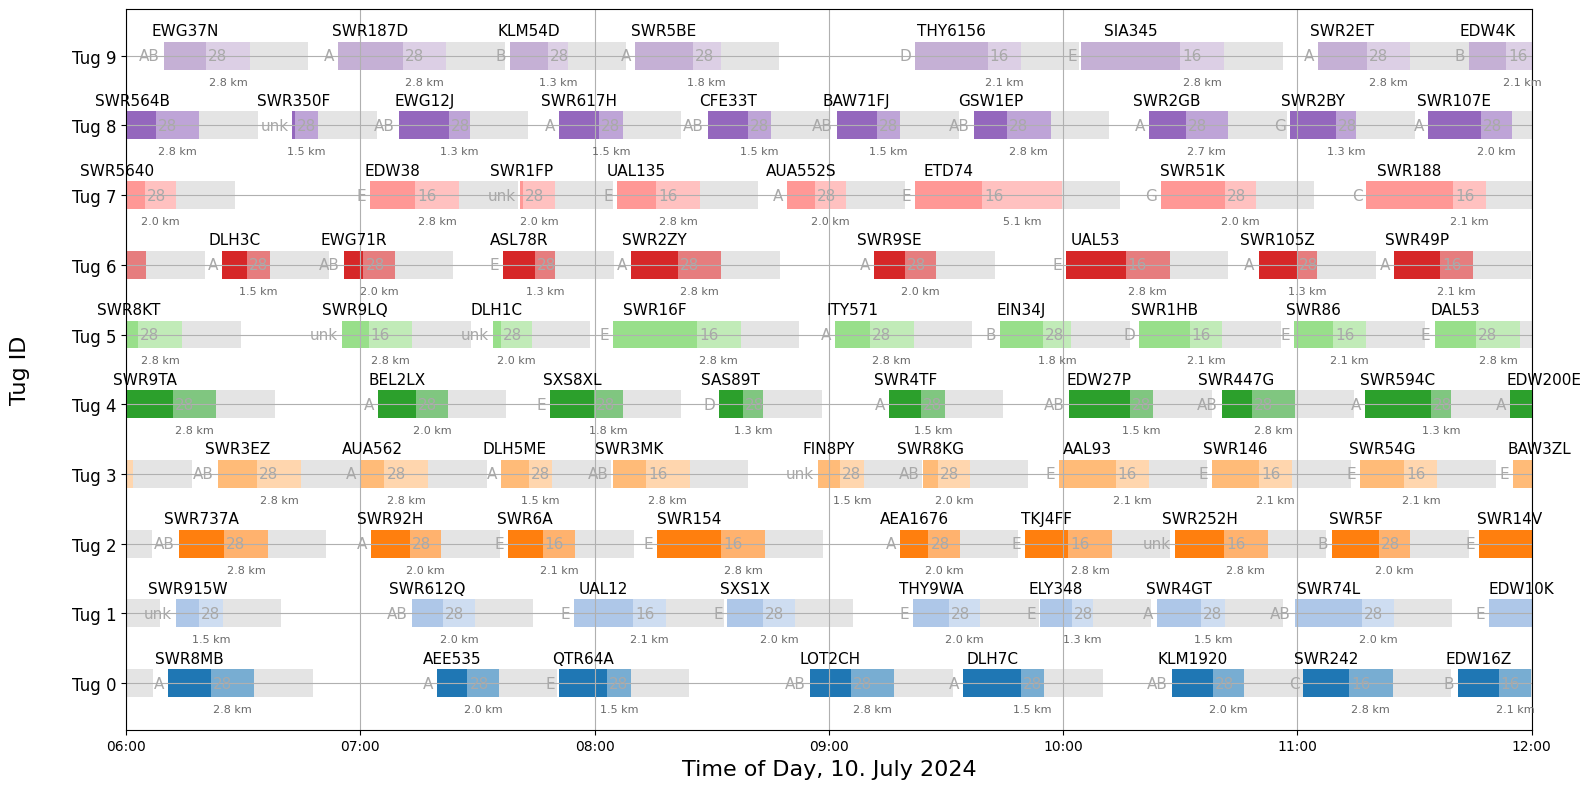

In [50]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Strip stand_area to first part before space
df_plot['stand_area_short'] = df_plot['stand_area'].astype(str).str.split().str[0]
df_plot['stand_area_short'] = df_plot['stand_area_short'].replace({'unknown': 'unk'})

# Tug positions and colors
tug_ids = sorted(df_plot['Assigned_Tug'].unique())
tug_to_y = {tug_id: i for i, tug_id in enumerate(tug_ids)}
cmap = plt.get_cmap("tab20")
colors = {tug_id: cmap(i % 20) for i, tug_id in enumerate(tug_ids)}

# Zoom range: 10:00 to 14:00
first_date = df_plot['startMovement'].dt.normalize().iloc[0]
xmin = pd.Timestamp.combine(first_date, pd.to_datetime("06:00").time())
xmax = pd.Timestamp.combine(first_date, pd.to_datetime("12:00").time())

# Plot
fig, ax = plt.subplots(figsize=(16, 8))
plt.subplots_adjust(left=0.15, top=0.95)

for _, row in df_plot.iterrows():
    tug = row['Assigned_Tug']
    y = tug_to_y[tug]
    start = row['startMovement']
    end = row['lineupTime']
    bar_center = start + (end - start) / 2

    # Skip bars fully outside window
    if end < xmin or start > xmax:
        continue

    # Plot the bar
    ax.barh(
        y=y,
        width=end - start,
        left=start,
        height=0.4,
        color=colors[tug],
        align='center'
    )

    # Annotate callsign above the bar
    ax.text(
        x=bar_center,
        y=y + 0.25,
        s=row['callsign'],
        ha='center',
        va='bottom',
        fontsize=11,
        color='black'
    )

    # Only show stand_area if left edge is within view
    stand_x = start - pd.Timedelta(minutes=1)
    if stand_x >= xmin:
        ax.text(
            x=stand_x,
            y=y,
            s=row['stand_area_short'],
            ha='right',
            va='center',
            fontsize=11,
            color='darkgray'
        )

    # Only show runway if right edge is within view
    runway_x = end + pd.Timedelta(minutes=0.5)
    if runway_x <= xmax:
        ax.text(
            x=runway_x,
            y=y,
            s=str(row['takeoffRunway']),
            ha='left',
            va='center',
            fontsize=11,
            color='darkgray'
        )

for seg in drive_segments:
    tug_color = colors[seg['tug']]  # same color as used for the flight bar

    ax.barh(
        y=seg['y'],
        width=seg['end'] - seg['start'],
        left=seg['start'],
        height=0.4,
        color=tug_color,
        alpha=0.6,
        edgecolor='none',  # optionally remove edge to soften the effect
        align='center'
    )

    # Optional: annotate driving distance only if label is within zoom window
    label_x = seg['start'] + (seg['end'] - seg['start']) / 2
    if xmin <= label_x <= xmax:
        ax.text(
            x=label_x,
            y=seg['y'] - 0.3,
            s=f"{seg['distance']:.1f} km",
            ha='center',
            va='top',
            fontsize=8,
            color='dimgray'
        )


for seg in drive_segments:
    buffer_start = seg['end']
    buffer_end = buffer_start + buffer_time

    # Draw the buffer segment (light gray)
    ax.barh(
        y=seg['y'],
        width=buffer_end - buffer_start,
        left=buffer_start,
        height=0.4,
        color='lightgray',
        alpha=0.6,
        edgecolor='none',
        align='center'
    )

# Format axes
ax.set_yticks(list(tug_to_y.values()))
ax.set_yticklabels([f"Tug {tid}" for tid in tug_to_y.keys()], fontsize=12)
ax.set_xlabel(f"Time of Day, {plotdate.strftime("%-d. %B %Y")}", fontsize=fontsize_xylabels)
ax.set_ylabel("Tug ID", labelpad=30, fontsize=fontsize_xylabels)
#ax.set_title("Tug Usage with Stand Area and Runway Annotations")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(xmin, xmax)
#ax.set_ylim(-0.5, len(tug_to_y) - 0.5 + 1)  # leave space for top label
ax.grid(True)

plt.tight_layout()
plt.show()

In [42]:
start_date = datetime.date(2024, 7, 10)
end_date = datetime.date(2024, 7, 18)

df = results_dict['allTypes_allCombinations'][15]
df = df[df.lineupTime.dt.date.between(start_date, end_date)]

df_assigned = df[df['Assigned_Tug'].notna()].copy()

df_assigned['hour'] = df_assigned['startMovement'].dt.floor('h')
df_grouped = df_assigned.groupby(['hour', 'takeoffRunway']).size().reset_index(name='tug_movements')
df_pivot = df_grouped.pivot(index='hour', columns='takeoffRunway', values='tug_movements').fillna(0)

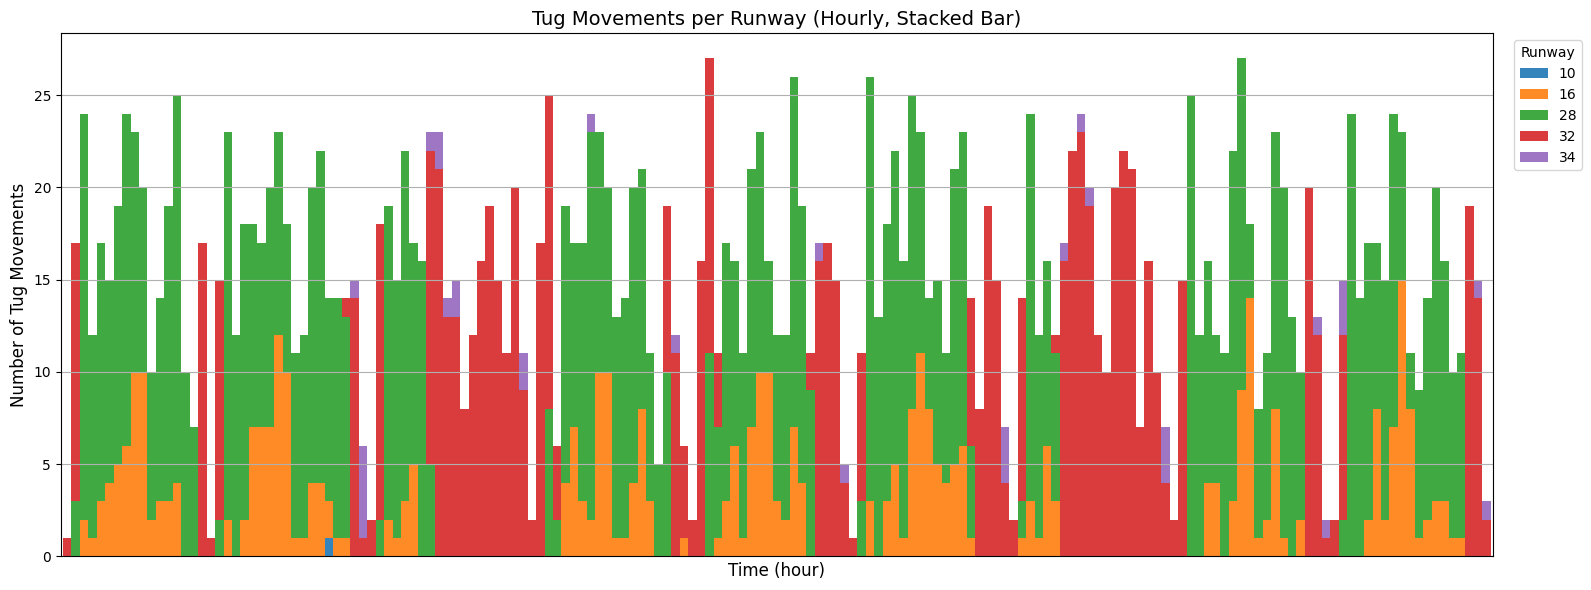

In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create 6-hour spaced ticks within data range
tick_range = pd.date_range(
    start=df_pivot.index.min().floor('D'),
    end=df_pivot.index.max().ceil('D'),
    freq='6h'
)

# Keep only ticks that are in the df_pivot index
valid_ticks = tick_range.intersection(df_pivot.index)

# Match ticks to positions (in bar chart index)
xtick_positions = [df_pivot.index.get_loc(t) for t in valid_ticks]
xtick_labels = pd.to_datetime(valid_ticks).strftime('%m-%d %H:%M')

# Plot
fig, ax = plt.subplots(figsize=(16, 6))

df_pivot.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    width=1.0,
    alpha=0.9
)

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=90)

ax.set_title("Tug Movements per Runway (Hourly, Stacked Bar)", fontsize=14)
ax.set_xlabel("Time (hour)", fontsize=12)
ax.set_ylabel("Number of Tug Movements", fontsize=12)
ax.legend(title="Runway", bbox_to_anchor=(1.01, 1), loc='upper left')
ax.grid(True)

plt.tight_layout()
plt.show()

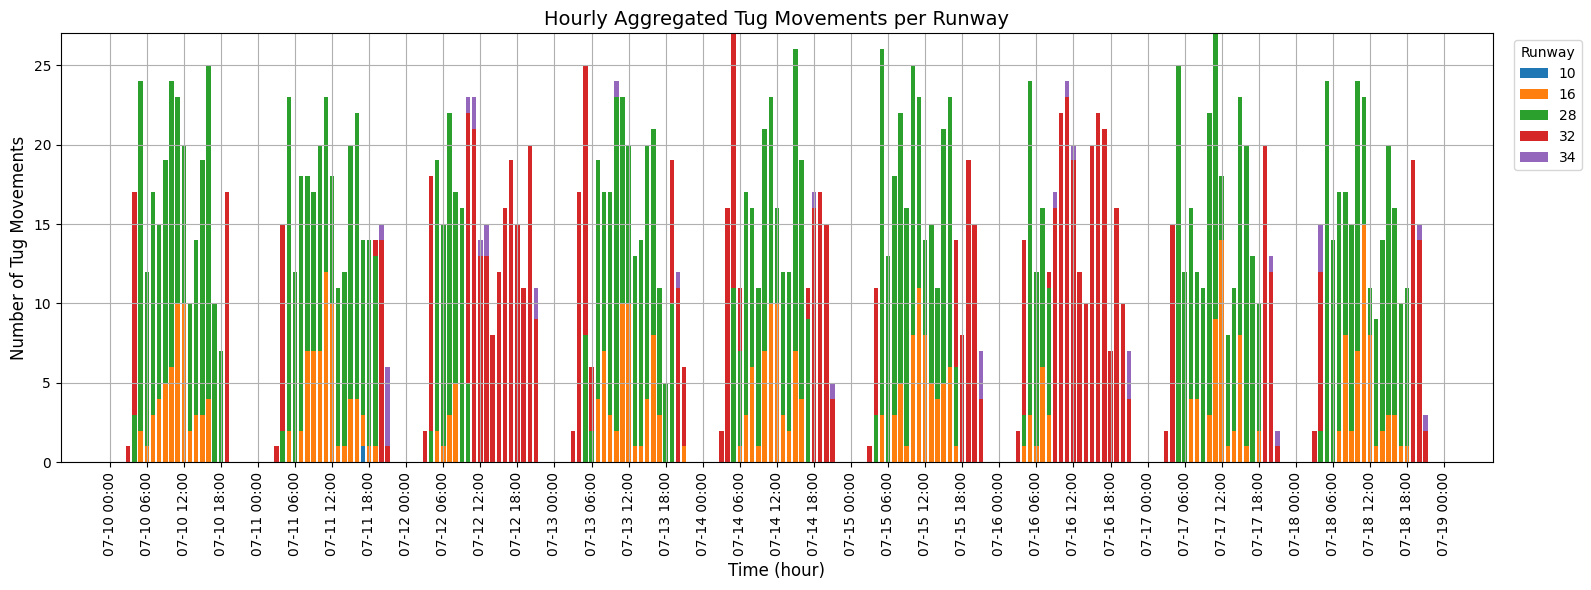

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# Reset index so 'hour' is a column
df_plot_ready = df_pivot.reset_index()

# Plot
fig, ax = plt.subplots(figsize=(16, 6))

# Plot each runway as stacked bars
bottom = pd.Series([0]*len(df_plot_ready))
for runway in df_pivot.columns:
    ax.bar(df_plot_ready['hour'], df_plot_ready[runway], bottom=bottom, label=runway, width=0.03)
    bottom += df_plot_ready[runway]

# Set x-ticks every 6 hours
tick_range = pd.date_range(
    start=df_plot_ready['hour'].min().floor('D'),
    end=df_plot_ready['hour'].max().ceil('D'),
    freq='6h'
)
ax.set_xticks(tick_range)
ax.set_xticklabels(tick_range.strftime('%m-%d %H:%M'), rotation=90)

# Labels, title, grid
ax.set_title("Hourly Aggregated Tug Movements per Runway", fontsize=14)
ax.set_xlabel("Time (hour)", fontsize=12)
ax.set_ylabel("Number of Tug Movements", fontsize=12)
ax.legend(title="Runway", bbox_to_anchor=(1.01, 1), loc='upper left')
ax.grid(True)

plt.tight_layout()
plt.show()